In [2]:
import numpy as np
from osgeo import gdal
import os
import glob
import cv2
import matplotlib.pyplot as plt
from scipy.misc import bytescale
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers.advanced_activations import LeakyReLU 
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split

/home/ks7585/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ks7585/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Data Preparation. 

1. Given that the image data consists of 13 channels. I used the **gdal** package to open the image data. OpenCV, PIL didn't perform well in exporting the right data. The description also provided details on the Red, Green, Blue (RGB) color channels. I tried to pull in the R,G,B (4,3,2) band data as a numpy array readable by OpenCV. <br>
2. Then the 3 data channeled array is merged together to form the RGB image <br> I tried visualizing the different dataset classes. Also, the RGB merged image consists of 16-bit dtype. <br> 
3. So, every image is converted to 8-bit dtype  with the help of **bytescale** from **scipy.mics**.
4. Then i set-up a Loop through all the data folders to perform the same operation and also add the folder name to list everytime an image is read.

***
>  ***for every folder (gdal read image --> extract RGB data --> Merge RGB --> convert to 8-bit --> Data.append and Label.append)***
***

In [3]:
path = "/home/ks7585/one/"
classes = [0,1,2,3,4,5,6,7,8,9]
target_height= 224
target_width= 224
data = []
labels = []
dataDistributionCounter=0
dataDistributionList =[]


In [4]:
for lab in classes:
    for imagePath in glob.glob(path+'/'+str(lab)+'/train_*.tif'):
        channels= gdal.Open(imagePath)
        R= np.array(channels.GetRasterBand(4).ReadAsArray(),dtype="float") / 255.0 # Getting the Red channel array from the image
        G= np.array(channels.GetRasterBand(3).ReadAsArray(),dtype="float") / 255.0 # Getting the Green Channel array from the image
        B= np.array(channels.GetRasterBand(2).ReadAsArray(),dtype="float") / 255.0 # Getting the Blue channel array from the image
        #print(R.shape,B.shape,G.shape)
        img = cv2.merge((B,G,R))                      # Merging 3 channels to make it a RGB image
        img = bytescale(img)                          # Scaling the 16-bit image to 8-bit
        data.append(cv2.resize(img,(target_width,target_height)))
        labels.append(lab)
        dataDistributionCounter+=1
    dataDistributionList.append(dataDistributionCounter)
    dataDistributionCounter = 0
    print("Data Folder ", lab, "done")

/home/ks7585/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  if __name__ == '__main__':


Current Data Folder - 0
Current Data Folder - 1
Current Data Folder - 2
Current Data Folder - 3
Current Data Folder - 4
Current Data Folder - 5
Current Data Folder - 6
Current Data Folder - 7
Current Data Folder - 8
Current Data Folder - 9


In [5]:
data = np.array(data)
labels = np.array(labels)
print(data.shape)
print(labels.shape)

(20292, 224, 224, 3)
(20292,)


## Data Histogram:
Displaying the total number of data available for each class.

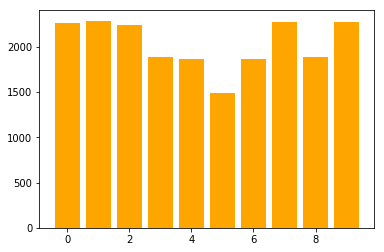

In [8]:
plt.bar(classes,dataDistributionList, color="orange")
plt.show()

In [9]:
(trainingImage, validationImage, trainLabel, validationLabel) = train_test_split(data,labels, test_size=0.25, random_state=42)
print(trainingImage.shape , validationImage.shape)

(15219, 224, 224, 3) (5073, 224, 224, 3)


In [10]:
# convert the labels from integers to vectors
trainLabelOneHotEncoded      = to_categorical(trainLabel, num_classes=10)
validationLabelOneHotEncoded = to_categorical(validationLabel, num_classes=10)

## Data Augmentation:
With the Bar Chart histogram on top displaying that the number of data available across all the classes is not equal. When having an uneven data, the model tends to lean more towards the class with highest data. In this point of time, collecting more data to equalize the classes isn't a feasible solution. So i performed Data Augmentation here. <br>
For Data Augmentation, i performed rotation, width and height shifting, shear intensity, zooming , along with horizontal flips

In [11]:
augmentation = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

## GPU limiting.

In [ ]:
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.visible_device_list = "0"
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

## Transfer Learning:
 Since this is a classification task, i performed transfer learning for the model to learn more from the available data. Keras has many predefined models like vggNet, ResNet, DenseNet, MobileNet. I tried playing around with different models. The data is reshaped according to the input shape of the model. The pretrained **ImageNet** weights are loaded to the model. The previous weights of the model is froze and the model doesn't update those weights. This is done so as to leaverage the learning of the model from the imagenet dataset. 
 <br>
 The activations of are averaged across each part of the image. Then the model is flattened out. The last fully connected layer is made to produce 10 probability outputs through softmax activation function. <br>
 Since it is a multiclass classification problem, Categorical crossentropy loss function is used. The learning rate is set to .003. <br>
 Across playing with different pretrained models, keras has a problem of utilizing most of the GPU and the CPU memory by loading the model and ImageNet weights into memory. VggNet is trained here by passing in the augmented data image and preventing overfitting by adding validation dataset for 30 epochs.

In [ ]:
#base_inception = InceptionV3(weights='imagenet', include_top=False,  input_shape=(299, 299, 3))
#res= keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(224, 224, 3))
vgg=keras.applications.vgg19.VGG19(include_top=False, weights='imagenet',input_shape=(target_width, target_height, 3))
#mob=keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),include_top=False, weights='imagenet')
out = vgg.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
#total_classes = y_train_ohe.shape[1]
predictions = Dense(10, activation='softmax')(out)

model = Model(inputs=vgg.input, outputs=predictions)

for layer in vgg.layers:
    layer.trainable = False
  
 
model.compile(Adam(lr=.003), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

In [ ]:

history = model.fit_generator(augmentation.flow(trainingImage, trainLabelOneHotEncoded, batch_size=1),
                              steps_per_epoch=250,
                              validation_data=(validationImage, validationLabelOneHotEncoded),
                              validation_steps=250 ,
                              epochs=30, verbose=1)

In [ ]:
model.save('karthik.hdf5')

print("Model Saved ")


In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,101))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()

## Testing:
The saved model is loaded from the disk to predict the test set. The testing set dataset is loaded and preprocessed similar to the training dataset and reshaped to the model input size. Then the model is made to predict on the test dataset. The predictions from the model is arranged in the form of Pandas DataFrame along with the data path. This dataframe is saved to a csv file.

In [12]:
from keras.models import load_model
model=load_model('karthik.hdf5')

In [14]:
testData = []
path= []
for imagePath in glob.glob('test_set/test*.tif'):
        testChannel= gdal.Open(imagePath)
        R= np.array(testChannel.GetRasterBand(4).ReadAsArray(),dtype="float") / 255.0 # Getting the Red channel array from the image
        G= np.array(testChannel.GetRasterBand(3).ReadAsArray(),dtype="float") / 255.0 # Getting the Green Channel array from the image
        B= np.array(testChannel.GetRasterBand(2).ReadAsArray(),dtype="float") / 255.0 # Getting the Blue channel array from the image
        #print(R.shape,B.shape,G.shape)
        img = cv2.merge((B,G,R))                      # Merging 3 channels to make it a RGB image
        img = bytescale(img)                          # Scaling the 16-bit image to 8-bit
        img = cv2.resize(img,(224,224))
        #plt.imshow(img)
        #image = img_to_array(img)
        testData.append (img)
        path.append ("./"+imagePath)
test_data = np.array(testData)

/home/ks7585/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  # Remove the CWD from sys.path while we load stuff.


In [15]:
predict = model.predict(test_data)


In [17]:
import pandas as pd
predictionsTest = pd.DataFrame(predict)
predictions = list(predictionsTest.idxmax(axis=1))
data_tuples = list(zip(path,predictions))
DataFrame=pd.DataFrame(data_tuples, columns=['filename','labels'])
DataFrame

,filename,labels
0,./test_set/test_4311.tif,7
1,./test_set/test_4089.tif,2
2,./test_set/test_1172.tif,9
3,./test_set/test_5447.tif,8
4,./test_set/test_183.tif,0
5,./test_set/test_3433.tif,7
6,./test_set/test_5385.tif,7
7,./test_set/test_5116.tif,3
8,./test_set/test_3135.tif,2
9,./test_set/test_144.tif,9


In [18]:
DataFrame.to_csv('test_labels.csv')

